In [ ]:
import zipfile

with zipfile.ZipFile('cnn_dataset.zip', 'r') as zip_ref:
  zip_ref.extractall('cnn_dataset')

In [2]:
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split

# Set the path to the root directory of your EMNIST dataset
emnist_root = 'cnn_dataset/cnn_dataset/'

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(),  # If images are not already grayscale
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load EMNIST dataset from local folders for letters and numbers
emnist_dataset = datasets.ImageFolder(root=emnist_root, transform=transform)

# Split the dataset into train and validation sets
total_size = len(emnist_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

# Use random_split to create train, validation, and test datasets
train_dataset, val_dataset, test_dataset = random_split(emnist_dataset, [train_size, val_size, test_size])

#create DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

# Print the sizes of each dataset
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 80640
Validation dataset size: 10080
Test dataset size: 10080


In [18]:
emnist_dataset

Dataset ImageFolder
    Number of datapoints: 100800
    Root location: cnn_dataset/cnn_dataset/
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [4]:
len(emnist_dataset)

100800

In [6]:
#Image size
emnist_dataset[0][0].shape

torch.Size([1, 28, 28])

In [8]:
#statistics
# Extract data from the dataset
emnist_data = torch.cat([sample[0].view(-1) for sample in emnist_dataset], dim=0)
mean_test = emnist_data.mean().item()
std_test = emnist_data.std().item()


In [10]:
print("Mean:", mean_test)
print("Standard Deviation:", std_test)

Mean: -0.6483684182167053
Standard Deviation: 0.6673614978790283


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

batch_size = 64

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


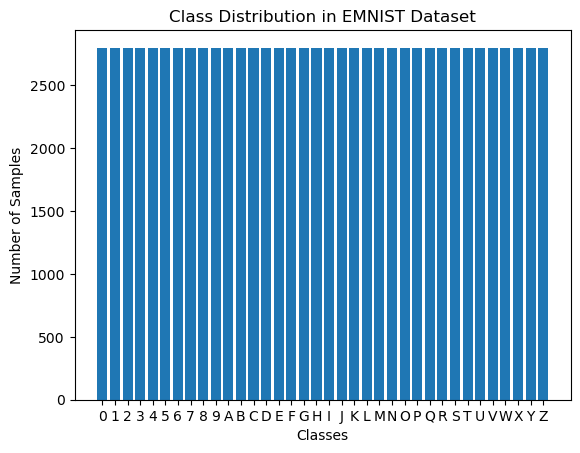

In [5]:
import matplotlib.pyplot as plt

# Display class distribution bar chart
class_counts = torch.tensor(emnist_dataset.targets).bincount()
class_labels = [emnist_dataset.classes[i] for i in range(len(class_counts))]
plt.bar(class_labels, class_counts)
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in EMNIST Dataset')
plt.show()

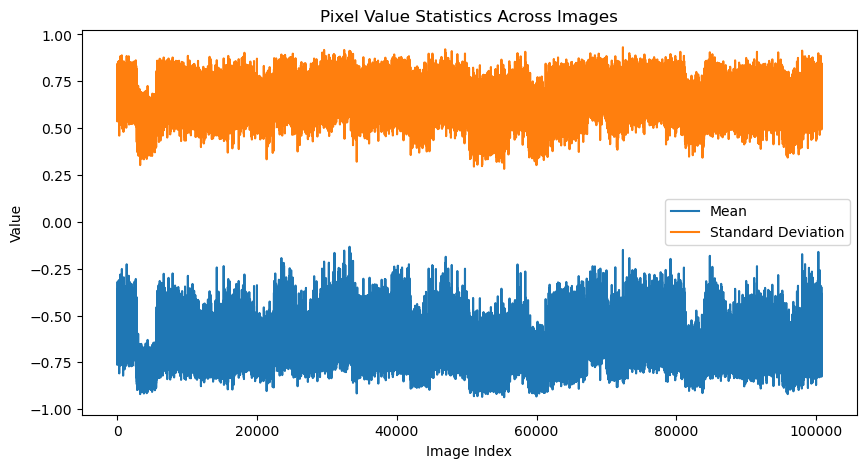

In [7]:
# Function to display image statistics
def show_image_statistics(emnist_dataset):
    img_means = []
    img_stds = []

    for img, _ in emnist_dataset:
        img_means.append(torch.mean(img))
        img_stds.append(torch.std(img))

    plt.figure(figsize=(10, 5))
    plt.plot(img_means, label='Mean')
    plt.plot(img_stds, label='Standard Deviation')
    plt.xlabel('Image Index')
    plt.ylabel('Value')
    plt.title('Pixel Value Statistics Across Images')
    plt.legend()
    plt.show()

# Show image statistics for the entire dataset
show_image_statistics(emnist_dataset)

# CNN Architecture Design

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 36)  # Output size for 36 characters

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        # Apply softmax activation to the output layer
        x = F.softmax(x, dim=1)
        return x

# Create an instance of the model
model = SimpleCNN()

In [ ]:
model = SimpleCNN()
print(model)

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=36, bias=True)
)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import time
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Step 4: Train your model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [28]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import time
import seaborn as sns
import matplotlib.pyplot as plt
def train(model, train_loader, val_loader, criterion, optimizer, epochs=5, early_stopping_patience=3):
    train_accuracy_list, val_accuracy_list = [], []
    train_loss_list, val_loss_list = [], []

    best_val_accuracy = 0
    early_stopping_counter = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch in train_loader:
            inputs, labels = batch
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = correct_train / total_train
        train_loss = running_loss / len(train_loader)

        # Validation
        model.eval()
        correct_val = 0
        total_val = 0
        val_running_loss = 0.0

        with torch.no_grad():
            for batch in val_loader:
                inputs, labels = batch
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

            val_accuracy = correct_val / total_val
            val_loss = val_running_loss / len(val_loader)

        print(f"Epoch {epoch + 1}/{epochs} => "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        train_accuracy_list.append(train_accuracy)
        val_accuracy_list.append(val_accuracy)
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)

        # Check for early stopping
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping!")
            break
        # Save model
        torch.save(model, 'model_eminst.h5')    

    return train_accuracy_list, val_accuracy_list, train_loss_list, val_loss_list

#Train the model
train_accuracy_list, val_accuracy_list, train_loss_list, val_loss_list = train(
    model, train_loader, val_loader, criterion, optimizer, epochs=5, early_stopping_patience=1
)

Epoch 1/5 => Train Loss: 0.5786, Train Accuracy: 0.8133, Val Loss: 0.3525, Val Accuracy: 0.8800
Epoch 2/5 => Train Loss: 0.2986, Train Accuracy: 0.8911, Val Loss: 0.2936, Val Accuracy: 0.8916
Epoch 3/5 => Train Loss: 0.2548, Train Accuracy: 0.9039, Val Loss: 0.2679, Val Accuracy: 0.9043
Epoch 4/5 => Train Loss: 0.2236, Train Accuracy: 0.9144, Val Loss: 0.2959, Val Accuracy: 0.8946
Early stopping!


In [29]:
model = torch.load('model_eminst.h5')

In [33]:
# Evaluate the performance of the model

def evaluate(model, data_loader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in data_loader:
            inputs, labels = batch
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            # Compute the loss
            test_loss = criterion(outputs.squeeze(), labels)
            all_labels.extend(labels.numpy())
            all_preds.extend(preds.numpy())

    accuracy = (torch.tensor(all_labels) == torch.tensor(all_preds)).float().mean().item()
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

    return accuracy, precision, recall, f1, all_labels, all_preds, test_loss

# Measure time to evaluate
start_time = time.time()
# Step 7: Evaluate on the testing data
test_accuracy, test_precision, test_recall, test_f1, all_labels, all_preds, test_loss = evaluate(model, test_loader)

# Calculate time taken to evaluate
evaluation_time = time.time() - start_time
print(f'Time to Evaluate: {evaluation_time:.2f} seconds')
print(f"Test Accuracy: {test_accuracy:.4f}, "
      f"Test Precision: {test_precision:.4f}, "
      f"Test Recall: {test_recall:.4f}, "
      f"Test F1 Score: {test_f1:.4f}")

Time to Evaluate: 155.73 seconds
Test Accuracy: 0.8964, Test Precision: 0.8981, Test Recall: 0.8964, Test F1 Score: 0.8959


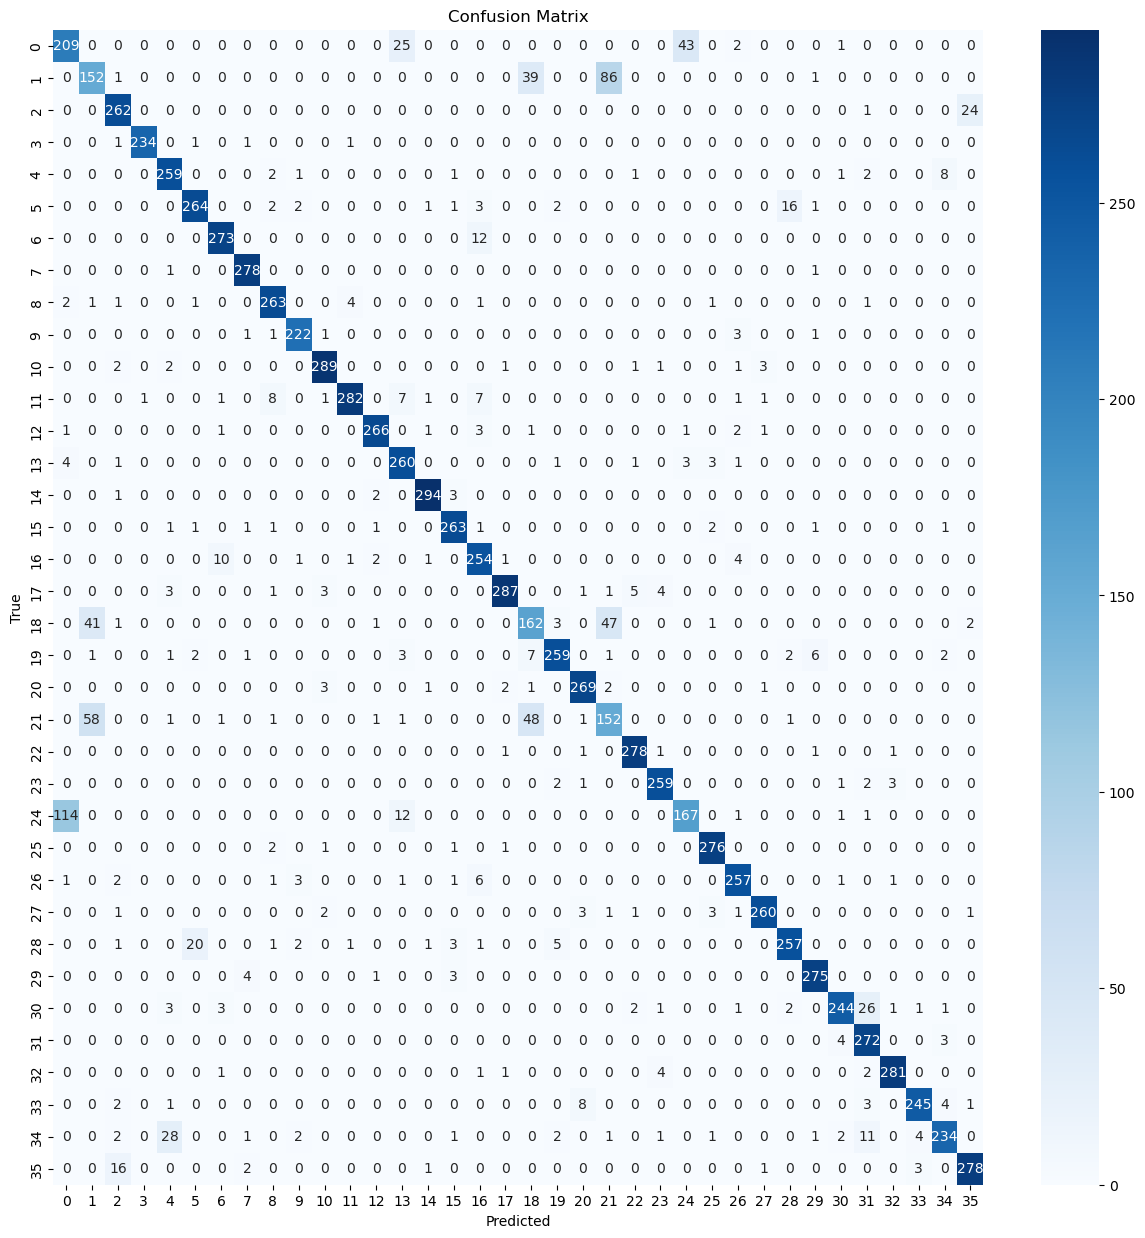

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

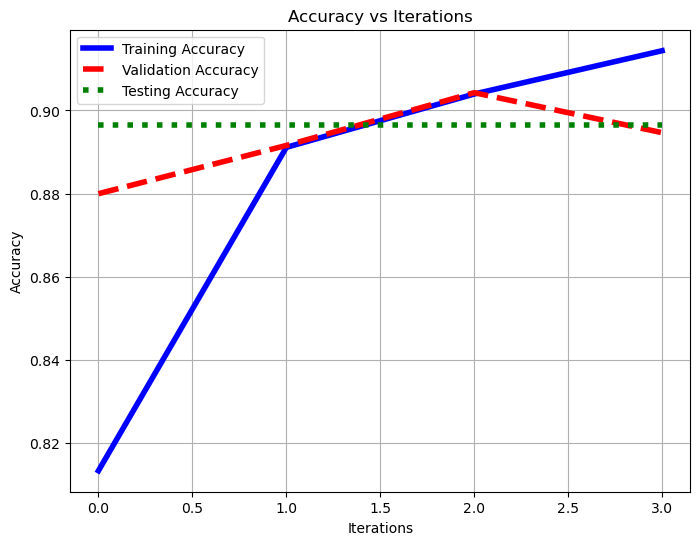

In [37]:
import matplotlib.pyplot as plt
x= [i for i in range(0,4)]

plt.figure(figsize=(8, 6))
plt.plot(x, train_accuracy_list, color='blue', linestyle='-', label='Training Accuracy',linewidth=4)
plt.plot(x, val_accuracy_list , color='red', linestyle='--', label='Validation Accuracy',linewidth=4)
plt.plot(x, [test_accuracy]*4 , color='green', linestyle=':', label='Testing Accuracy',linewidth=4)

plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Iterations')
plt.legend()
plt.grid(True)

plt.show()

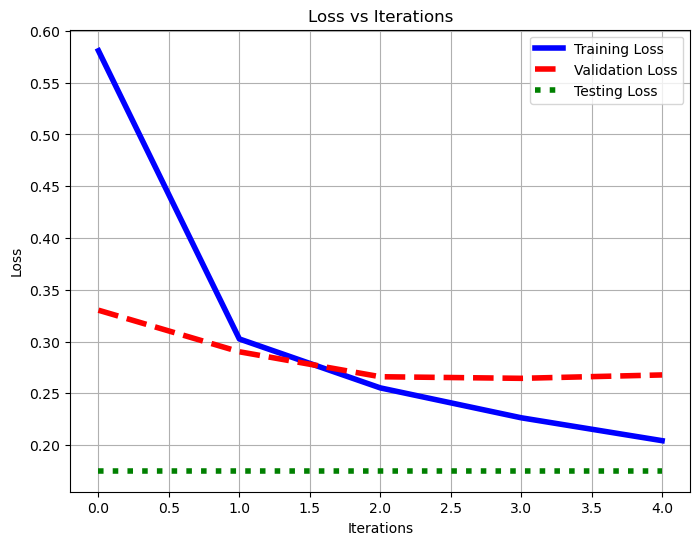

In [40]:
import matplotlib.pyplot as plt
x= [i for i in range(0,5)]

plt.figure(figsize=(8, 6))
plt.plot(x, train_loss_list, color='blue', linestyle='-', label='Training Loss',linewidth=4)
plt.plot(x, val_loss_list, color='red', linestyle='--', label='Validation Loss',linewidth=4)
plt.plot(x, [test_loss]*len(val_loss_list) , color='green', linestyle=':', label='Testing Loss',linewidth=4)

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs Iterations')
plt.legend()
plt.grid(True)

plt.show()

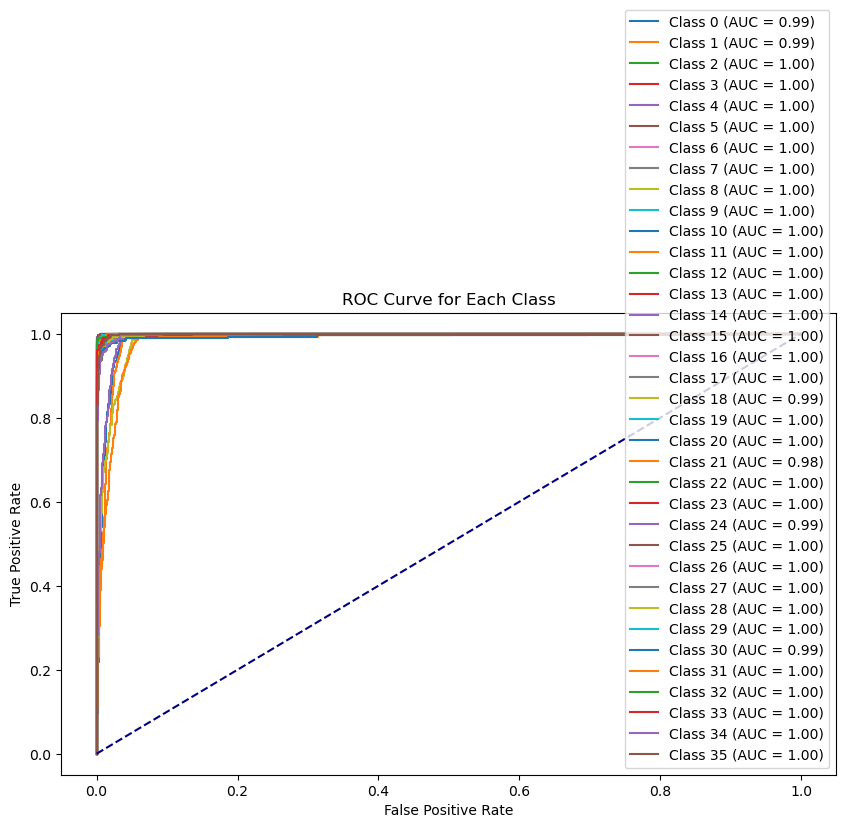

In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

model.eval()
all_true_labels, all_pred_probs = [], []
with torch.no_grad():
    for i, lab in test_loader:
        op = model(i)
        softmax_probs = torch.nn.functional.softmax(op, dim=1)
        all_true_labels.extend(lab.cpu().numpy())
        all_pred_probs.extend(softmax_probs.cpu().numpy())

num_classes = 36
true_labels_onehot = np.eye(num_classes)[all_true_labels]


fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_onehot[:, i], np.array(all_pred_probs)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.show()

# VGG - 11 Implementation

In [9]:
import torch
import torch.nn as nn

class VGG11(nn.Module):
    def __init__(self, num_classes=47):
        super(VGG11, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [10]:
import time
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

# Assuming you have your EMNIST data loaders ready (train_loader, val_loader, test_loader)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the VGG-11 model
model = VGG11(num_classes=36).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Training and validation loop
start_time = time.time()
num_epochs = 5

train_losses, val_losses, test_losses = [], [], []
train_accuracies, val_accuracies, test_accuracies = [], [], []

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        _, predicted_train = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted_val = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Test
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, predicted_test = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted_test == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = correct_test / total_test
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}, "
          f"Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Calculate training time
training_time = time.time() - start_time

Epoch [1/5] - Training Loss: 3.5840, Validation Loss: 3.5846, Test Loss: 3.5845, Training Accuracy: 0.0277, Validation Accuracy: 0.0255, Test Accuracy: 0.0242
Epoch [2/5] - Training Loss: 2.1578, Validation Loss: 0.3565, Test Loss: 0.3656, Training Accuracy: 0.3959, Validation Accuracy: 0.8767, Test Accuracy: 0.8709
Epoch [3/5] - Training Loss: 0.3386, Validation Loss: 0.2343, Test Loss: 0.2434, Training Accuracy: 0.8783, Validation Accuracy: 0.9142, Test Accuracy: 0.9080
Epoch [4/5] - Training Loss: 0.2542, Validation Loss: 0.2272, Test Loss: 0.2331, Training Accuracy: 0.9040, Validation Accuracy: 0.9156, Test Accuracy: 0.9105
Epoch [5/5] - Training Loss: 0.2181, Validation Loss: 0.2232, Test Loss: 0.2233, Training Accuracy: 0.9156, Validation Accuracy: 0.9127, Test Accuracy: 0.9126


In [11]:
# Calculate accuracy, precision, recall, and F1 score on the test set
model.eval()
all_true_labels, all_pred_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_true_labels.extend(labels.cpu().numpy())
        all_pred_labels.extend(predicted.cpu().numpy())

# Calculate accuracy, precision, recall, and F1 score on the test set
accuracy = accuracy_score(all_true_labels, all_pred_labels)
precision, recall, f1, _ = precision_recall_fscore_support(all_true_labels, all_pred_labels, average='weighted')

print(f"Training Time: {training_time:.2f} seconds")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Training Time: 3513.58 seconds
Accuracy: 0.9126
Precision: 0.9177
Recall: 0.9126
F1 Score: 0.9112


In [13]:
torch.save(model, 'vgg11.h5')

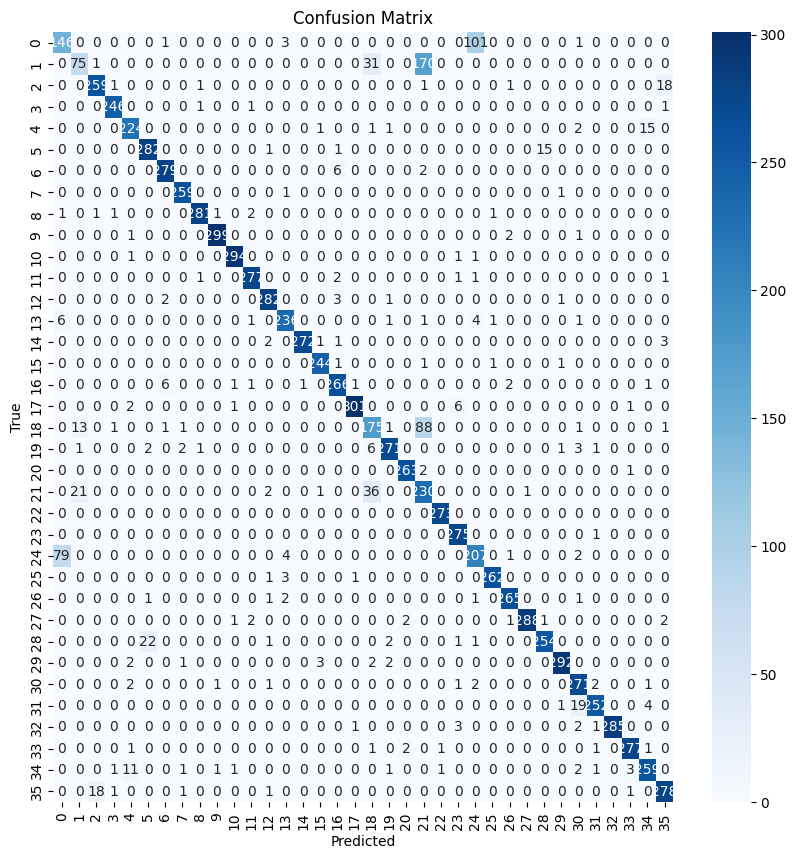

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrix
cm = confusion_matrix(all_true_labels, all_pred_labels)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

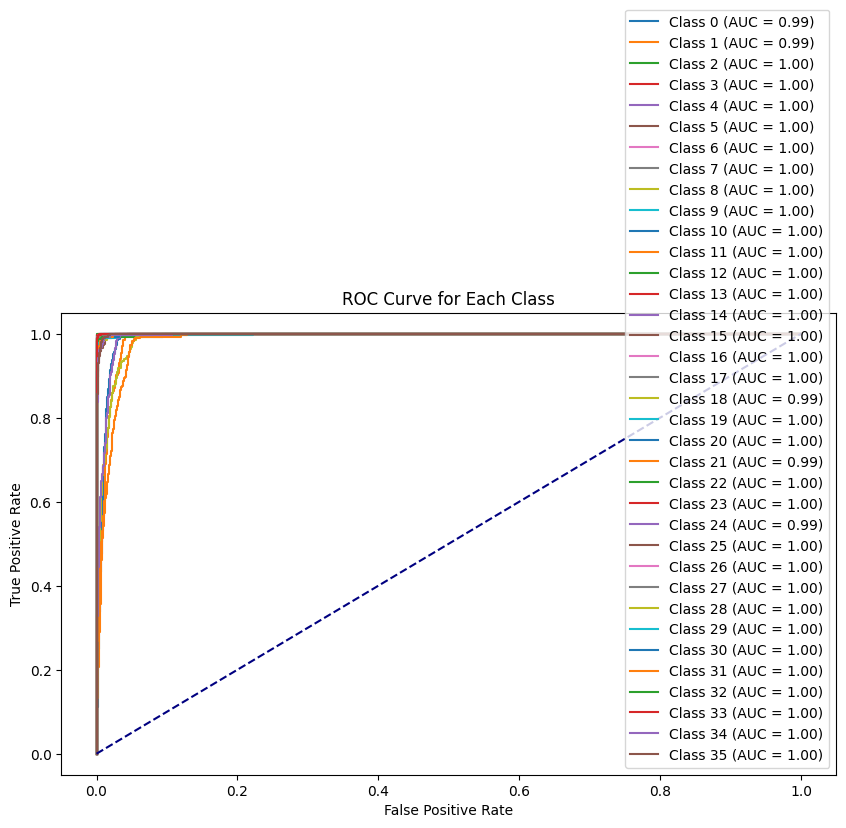

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

model.eval()
all_true_labels, all_pred_probs = [], []
with torch.no_grad():
    for i, lab in test_loader:
        i, lab = i.to(device), lab.to(device)
        op = model(i)
        softmax_probs = torch.nn.functional.softmax(op, dim=1)
        all_true_labels.extend(lab.cpu().numpy())
        all_pred_probs.extend(softmax_probs.cpu().numpy())

num_classes = 36
true_labels_onehot = np.eye(num_classes)[all_true_labels]


fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_onehot[:, i], np.array(all_pred_probs)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.show()